# B-CNN on CIFAR-10

Author: Yingjie Gong\
student number: 20144264

**Description:** \
Here below is the code implementation of B-CNN model on CIFAR10 dataset\
50000 for training, 10000 for testing\
60 epochs in total.\
Learning rate start from 0.003, 0.0005 after 40 epochs\
0.0001 after 50 epochs\
Loss weight is initialized as [0.98, 0.01, 0.01]\
Referring to https://arxiv.org/abs/1709.09890



# Packages used


In [1]:
import keras
import numpy as np
import os
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.initializers import he_normal
from keras import optimizers
from keras.callbacks import LearningRateScheduler, TensorBoard
from tensorflow.keras.layers import BatchNormalization
from keras.utils.data_utils import get_file
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plot
import matplotlib.pyplot as plt 
import matplotlib.style as psl
from sklearn.metrics import confusion_matrix      
import seaborn as sn; sn.set(font_scale=1.4)

# Training settings

In [2]:
#-------------------- learing rate adjusting rules ----------------------
def scheduler(epoch):
  learning_rate_init = 0.003
  if epoch > 40:
    learning_rate_init = 0.0005
  if epoch > 50:
    learning_rate_init = 0.0001
  return learning_rate_init

#-------------------- loss weight adjusting rules ----------------------
class LossWeightsModifier(keras.callbacks.Callback):
  def __init__(self, alpha, beta, gamma):
    self.alpha = alpha
    self.beta = beta
    self.gamma = gamma
  def on_epoch_end(self, epoch, logs={}):
    if epoch == 8:
      K.set_value(self.alpha, 0.1)
      K.set_value(self.beta, 0.8)
      K.set_value(self.gamma, 0.1)
    if epoch == 18:
      K.set_value(self.alpha, 0.1)
      K.set_value(self.beta, 0.2)
      K.set_value(self.gamma, 0.7)
    if epoch == 28:
      K.set_value(self.alpha, 0)
      K.set_value(self.beta, 0)
      K.set_value(self.gamma, 1)

train_size = 50000

#--- coarse 1 classes ---
num_c_1 = 2
#--- coarse 2 classes ---
num_c_2 = 7
#--- fine classes ---
num_classes  = 10

batch_size   = 128
epochs       = 60

#--- file paths ---
log_filepath = './tb_log_vgg16/'
weights_store_filepath = './vgg16_weights/'
retrain_id = '101'
model_name = 'weights_vgg16_cifar_100_'+retrain_id+'.h5'
model_path = os.path.join(weights_store_filepath, model_name)

#----------get VGG16 pre-trained weights--------
WEIGHTS_PATH = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels.h5'
weights_path = get_file('vgg16_weights_tf_dim_ordering_tf_kernels.h5',
                         WEIGHTS_PATH,
                         cache_subdir='models')


# Dimensions

In [3]:
img_rows, img_cols = 32, 32
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_rows, img_cols)
else:
    input_shape = (img_rows, img_cols, 3)

# Data loading& preprocess

In [4]:
#-------------------- data loading ----------------------
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
labels = y_train.flatten()
images = x_train
test_images = x_test
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#---------------- data preprocessiong -------------------
x_train = (x_train-np.mean(x_train)) / np.std(x_train)
x_test = (x_test-np.mean(x_test)) / np.std(x_test)
print(type(x_train))

<class 'numpy.ndarray'>


# Data visualizing

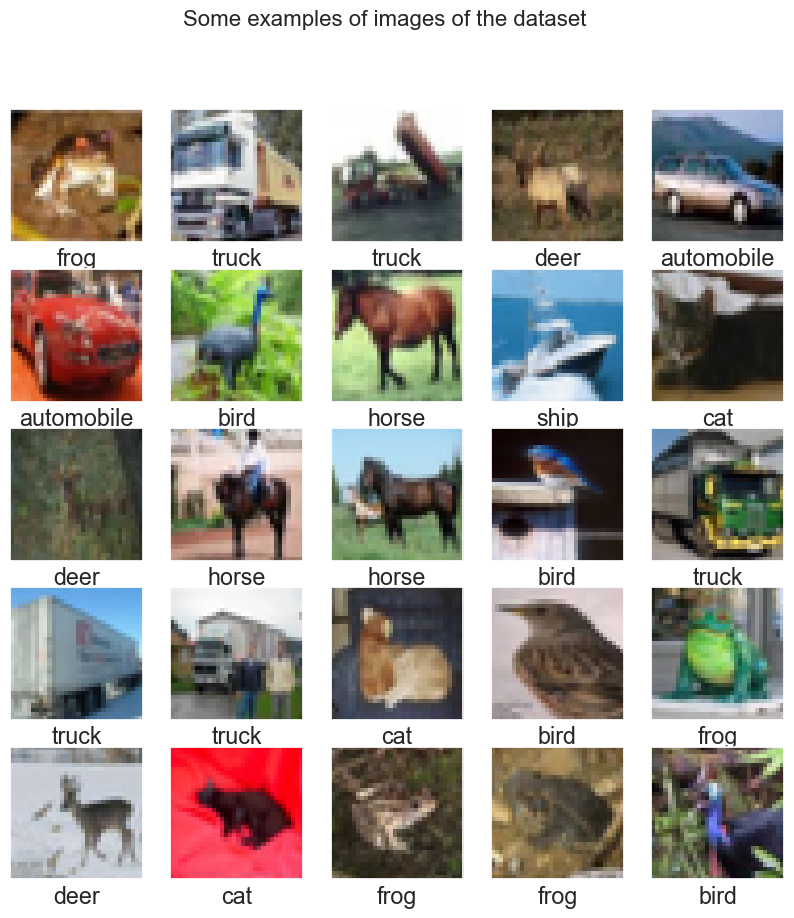

In [5]:
def display_examples(class_names, images, labels, title = "Some examples of images of the dataset"):
    """
        Display 25 images from the images array with its corresponding labels
    """

    fig = plt.figure(figsize=(10,10))
    fig.suptitle(title, fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i],cmap = 'gray')
        plt.xlabel(class_names[labels[i]])
    plt.show()

#---------------------- calling to show --------------------------
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
display_examples(classes, images, labels)

# Create Labels for 2 coarses

In [6]:
#---------------------- make coarse 2 labels --------------------------
parent_f = {
  2:3, 3:5, 5:5,
  1:2, 7:6, 4:6,
  0:0, 6:4, 8:1, 9:2
}
y_c2_train = np.zeros((y_train.shape[0], num_c_2)).astype("float32")
y_c2_test = np.zeros((y_test.shape[0], num_c_2)).astype("float32")
for i in range(y_c2_train.shape[0]):
  y_c2_train[i][parent_f[np.argmax(y_train[i])]] = 1.0
for i in range(y_c2_test.shape[0]):
  y_c2_test[i][parent_f[np.argmax(y_test[i])]] = 1.0

#---------------------- make coarse 1 labels --------------------------
parent_c2 = {
  0:0, 1:0, 2:0,
  3:1, 4:1, 5:1, 6:1
}
y_c1_train = np.zeros((y_c2_train.shape[0], num_c_1)).astype("float32")
y_c1_test = np.zeros((y_c2_test.shape[0], num_c_1)).astype("float32")
for i in range(y_c1_train.shape[0]):
  y_c1_train[i][parent_c2[np.argmax(y_c2_train[i])]] = 1.0
for i in range(y_c1_test.shape[0]):
  y_c1_test[i][parent_c2[np.argmax(y_c2_test[i])]] = 1.0

# Model Definition

In [7]:
#----------------------- model definition ---------------------------
alpha = K.variable(value=0.98, dtype="float32", name="alpha") 
beta = K.variable(value=0.01, dtype="float32", name="beta") 
gamma = K.variable(value=0.01, dtype="float32", name="gamma") 

img_input = Input(shape=input_shape, name='input')

#--- block 1 ---
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1')(img_input)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

#--- block 2 ---
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

#--- coarse 1 branch ---
c_1_bch = Flatten(name='c1_flatten')(x)
c_1_bch = Dense(256, activation='relu', name='c1_fc_cifar10_1')(c_1_bch)
c_1_bch = BatchNormalization()(c_1_bch)
c_1_bch = Dropout(0.5)(c_1_bch)
c_1_bch = Dense(256, activation='relu', name='c1_fc2')(c_1_bch)
c_1_bch = BatchNormalization()(c_1_bch)
c_1_bch = Dropout(0.5)(c_1_bch)
c_1_pred = Dense(num_c_1, activation='softmax', name='c1_predictions_cifar10')(c_1_bch)

#--- block 3 ---
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2')(x)
x = BatchNormalization()(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

#--- coarse 2 branch ---
c_2_bch = Flatten(name='c2_flatten')(x)
c_2_bch = Dense(512, activation='relu', name='c2_fc_cifar10_1')(c_2_bch)
c_2_bch = BatchNormalization()(c_2_bch)
c_2_bch = Dropout(0.5)(c_2_bch)
c_2_bch = Dense(512, activation='relu', name='c2_fc2')(c_2_bch)
c_2_bch = BatchNormalization()(c_2_bch)
c_2_bch = Dropout(0.5)(c_2_bch)
c_2_pred = Dense(num_c_2, activation='softmax', name='c2_predictions_cifar10')(c_2_bch)

#--- block 4 ---
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

#--- block 5 ---
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2')(x)
x = BatchNormalization()(x)
x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3')(x)
x = BatchNormalization()(x)

#--- fine block ---
x = Flatten(name='flatten')(x)
x = Dense(4096, activation='relu', name='fc_cifar100_1')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu', name='fc_cifar100_2')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
fine_pred = Dense(num_classes, activation='softmax', name='predictions_cifar10')(x)

model = Model(img_input, [c_1_pred, c_2_pred, fine_pred], name='vgg16_hierarchy')
model.load_weights(weights_path, by_name=True)

# Compile and Fit

In [8]:
#----------------------- compile and fit ---------------------------
sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', 
              optimizer=sgd, 
              loss_weights=[alpha, beta, gamma], 
              # optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
tb_cb = TensorBoard(log_dir=log_filepath, histogram_freq=0)
change_lr = LearningRateScheduler(scheduler)
change_lw = LossWeightsModifier(alpha, beta, gamma)
cbks = [change_lr, tb_cb, change_lw]

trained = model.fit(x_train, [y_c1_train, y_c2_train, y_train],
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          callbacks=cbks,
          validation_data=(x_test, [y_c1_test, y_c2_test, y_test]))


model.compile(loss=keras.losses.categorical_crossentropy,
              # optimizer=keras.optimizers.Adadelta(),
              optimizer=sgd, 
              metrics=['accuracy'])

model.save(model_path)
score = model.evaluate(x_test, [y_c1_test, y_c2_test, y_test], verbose=0)
print('score is: ', score)

C:\Users\25863\anaconda3\envs\Tensor_NIVDA\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/60
391/391 [==============================] - 30s 48ms/step - loss: 0.3147 - c1_predictions_cifar10_loss: 0.2690 - c2_predictions_cifar10_loss: 2.5751 - predictions_cifar10_loss: 2.5278 - c1_predictions_cifar10_accuracy: 0.8964 - c2_predictions_cifar10_accuracy: 0.2502 - predictions_cifar10_accuracy: 0.2961 - val_loss: 0.1915 - val_c1_predictions_cifar10_loss: 0.1691 - val_c2_predictions_cifar10_loss: 1.2981 - val_predictions_cifar10_loss: 1.2779 - val_c1_predictions_cifar10_accuracy: 0.9302 - val_c2_predictions_cifar10_accuracy: 0.5299 - val_predictions_cifar10_accuracy: 0.5579
Epoch 2/60
391/391 [==============================] - 16s 42ms/step - loss: 0.2117 - c1_predictions_cifar10_loss: 0.1790 - c2_predictions_cifar10_loss: 1.8392 - predictions_cifar10_loss: 1.7883 - c1_predictions_cifar10_accuracy: 0.9307 - c2_predictions_cifar10_accuracy: 0.4184 - predictions_cifar10_accuracy: 0.4755 - val_loss: 0.1737 - val_c1_predictions_cifar10_loss: 0.1552 - val_c2_predictions_cifar10

Epoch 14/60
391/391 [==============================] - 18s 45ms/step - loss: 0.2724 - c1_predictions_cifar10_loss: 0.0629 - c2_predictions_cifar10_loss: 0.2798 - predictions_cifar10_loss: 0.4227 - c1_predictions_cifar10_accuracy: 0.9769 - c2_predictions_cifar10_accuracy: 0.9021 - predictions_cifar10_accuracy: 0.8581 - val_loss: 0.3343 - val_c1_predictions_cifar10_loss: 0.1147 - val_c2_predictions_cifar10_loss: 0.3376 - val_predictions_cifar10_loss: 0.5276 - val_c1_predictions_cifar10_accuracy: 0.9576 - val_c2_predictions_cifar10_accuracy: 0.8865 - val_predictions_cifar10_accuracy: 0.8358
Epoch 15/60
391/391 [==============================] - 17s 44ms/step - loss: 0.2350 - c1_predictions_cifar10_loss: 0.0612 - c2_predictions_cifar10_loss: 0.2410 - predictions_cifar10_loss: 0.3612 - c1_predictions_cifar10_accuracy: 0.9765 - c2_predictions_cifar10_accuracy: 0.9147 - predictions_cifar10_accuracy: 0.8763 - val_loss: 0.3280 - val_c1_predictions_cifar10_loss: 0.1087 - val_c2_predictions_cifar

Epoch 28/60
391/391 [==============================] - 18s 45ms/step - loss: 0.0405 - c1_predictions_cifar10_loss: 0.0469 - c2_predictions_cifar10_loss: 0.0588 - predictions_cifar10_loss: 0.0344 - c1_predictions_cifar10_accuracy: 0.9827 - c2_predictions_cifar10_accuracy: 0.9801 - predictions_cifar10_accuracy: 0.9885 - val_loss: 0.6353 - val_c1_predictions_cifar10_loss: 0.1142 - val_c2_predictions_cifar10_loss: 0.3628 - val_predictions_cifar10_loss: 0.7876 - val_c1_predictions_cifar10_accuracy: 0.9596 - val_c2_predictions_cifar10_accuracy: 0.9023 - val_predictions_cifar10_accuracy: 0.8638
Epoch 29/60
391/391 [==============================] - 18s 46ms/step - loss: 0.0391 - c1_predictions_cifar10_loss: 0.0451 - c2_predictions_cifar10_loss: 0.0608 - predictions_cifar10_loss: 0.0321 - c1_predictions_cifar10_accuracy: 0.9834 - c2_predictions_cifar10_accuracy: 0.9794 - predictions_cifar10_accuracy: 0.9894 - val_loss: 0.6336 - val_c1_predictions_cifar10_loss: 0.1118 - val_c2_predictions_cifar

Epoch 42/60
391/391 [==============================] - 19s 48ms/step - loss: 0.0113 - c1_predictions_cifar10_loss: 0.0484 - c2_predictions_cifar10_loss: 0.0748 - predictions_cifar10_loss: 0.0113 - c1_predictions_cifar10_accuracy: 0.9817 - c2_predictions_cifar10_accuracy: 0.9741 - predictions_cifar10_accuracy: 0.9958 - val_loss: 0.7103 - val_c1_predictions_cifar10_loss: 0.1199 - val_c2_predictions_cifar10_loss: 0.3558 - val_predictions_cifar10_loss: 0.7103 - val_c1_predictions_cifar10_accuracy: 0.9589 - val_c2_predictions_cifar10_accuracy: 0.9025 - val_predictions_cifar10_accuracy: 0.8808
Epoch 43/60
391/391 [==============================] - 18s 47ms/step - loss: 0.0037 - c1_predictions_cifar10_loss: 0.0502 - c2_predictions_cifar10_loss: 0.0681 - predictions_cifar10_loss: 0.0037 - c1_predictions_cifar10_accuracy: 0.9804 - c2_predictions_cifar10_accuracy: 0.9774 - predictions_cifar10_accuracy: 0.9989 - val_loss: 0.7070 - val_c1_predictions_cifar10_loss: 0.1179 - val_c2_predictions_cifar

Epoch 56/60
391/391 [==============================] - 18s 45ms/step - loss: 9.7878e-04 - c1_predictions_cifar10_loss: 0.0489 - c2_predictions_cifar10_loss: 0.0635 - predictions_cifar10_loss: 9.7878e-04 - c1_predictions_cifar10_accuracy: 0.9810 - c2_predictions_cifar10_accuracy: 0.9783 - predictions_cifar10_accuracy: 0.9997 - val_loss: 0.7239 - val_c1_predictions_cifar10_loss: 0.1167 - val_c2_predictions_cifar10_loss: 0.3496 - val_predictions_cifar10_loss: 0.7239 - val_c1_predictions_cifar10_accuracy: 0.9594 - val_c2_predictions_cifar10_accuracy: 0.9032 - val_predictions_cifar10_accuracy: 0.8837
Epoch 57/60
391/391 [==============================] - 17s 44ms/step - loss: 8.2437e-04 - c1_predictions_cifar10_loss: 0.0490 - c2_predictions_cifar10_loss: 0.0626 - predictions_cifar10_loss: 8.2437e-04 - c1_predictions_cifar10_accuracy: 0.9815 - c2_predictions_cifar10_accuracy: 0.9791 - predictions_cifar10_accuracy: 0.9998 - val_loss: 0.7242 - val_c1_predictions_cifar10_loss: 0.1164 - val_c2_p

# Plot& Evaluation

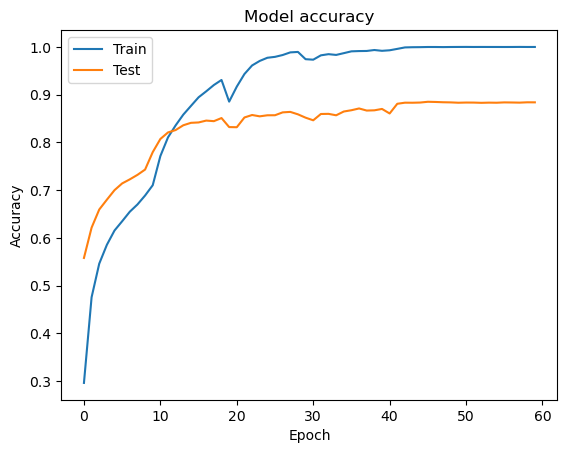

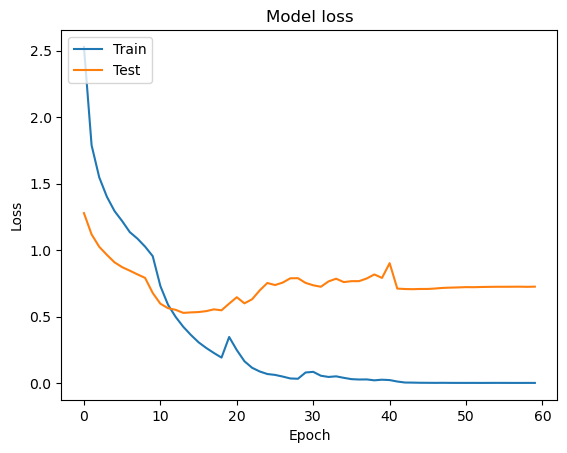

In [9]:
plot.rcdefaults ()
plot.plot(trained.history['predictions_cifar10_accuracy'])
plot.plot(trained.history['val_predictions_cifar10_accuracy'])
plot.title('Model accuracy')
plot.ylabel('Accuracy')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()


plot.plot(trained.history['predictions_cifar10_loss'])
plot.plot(trained.history['val_predictions_cifar10_loss'])
plot.title('Model loss')
plot.ylabel('Loss')
plot.xlabel('Epoch')
plot.legend(['Train', 'Test'], loc='upper left')
plot.show()

In [10]:
predictions = model.predict(x_test)     # Vector of probabilities
pred_labels = np.argmax(predictions[-1], axis = 1) # We take the highest probability

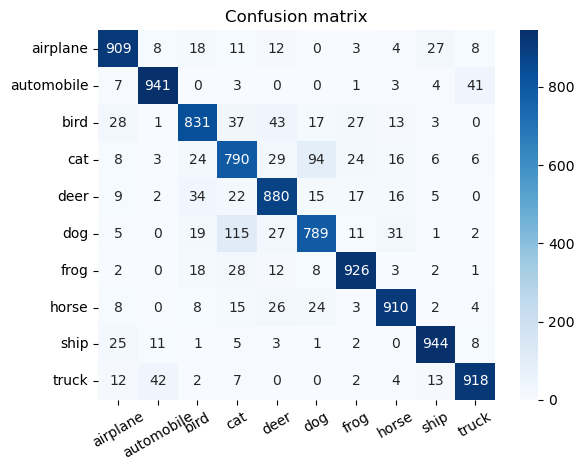

In [11]:
test_labels = np.argmax(y_test, axis = 1)
CM = confusion_matrix(test_labels, pred_labels)
ax = plt.axes()
sn.heatmap(CM, annot=True,
           cmap=plt.cm.Blues,
           annot_kws={"size": 10}, 
           xticklabels=classes, 
           yticklabels=classes, ax = ax, fmt="d")

plt.xticks(rotation=30)
ax.set_title('Confusion matrix')

plt.show()


# Miss classification sample

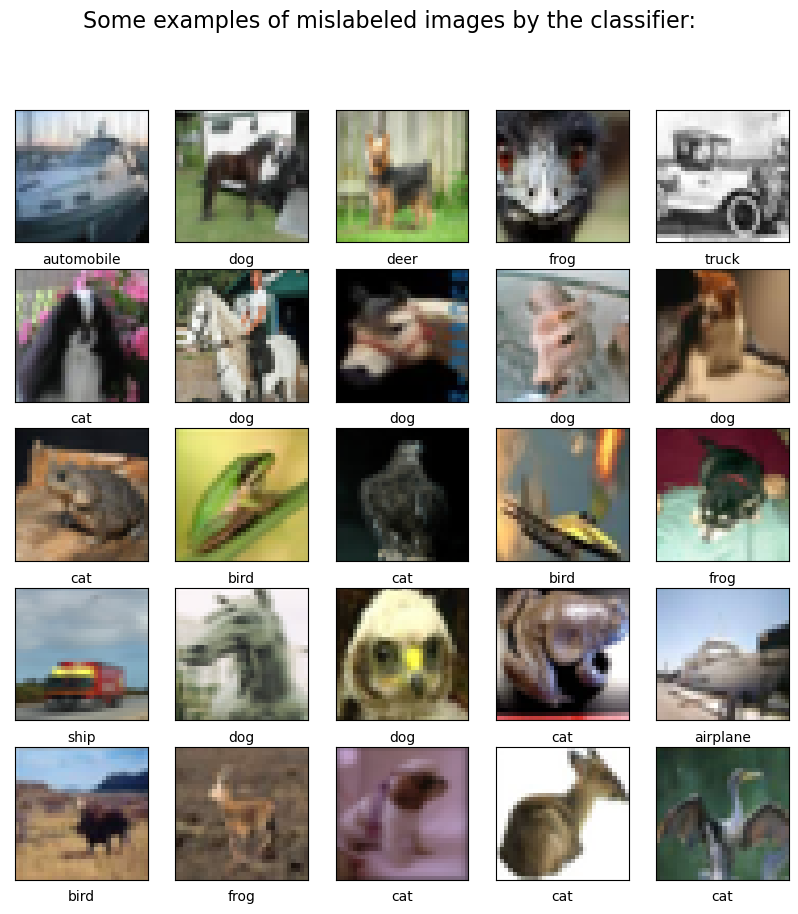

In [12]:
def print_mislabeled_images(class_names, test_images, test_labels, pred_labels):
    """
        Print 25 examples of mislabeled images by the classifier, e.g when test_labels != pred_labels
    """
    BOO = (test_labels == pred_labels)
    mislabeled_indices = np.where(BOO == 0)
    mislabeled_images = test_images[mislabeled_indices]
    mislabeled_labels = pred_labels[mislabeled_indices]

    title = "Some examples of mislabeled images by the classifier:"
    display_examples(class_names,  mislabeled_images, mislabeled_labels, title)

print_mislabeled_images(classes, test_images, test_labels, pred_labels)

cat


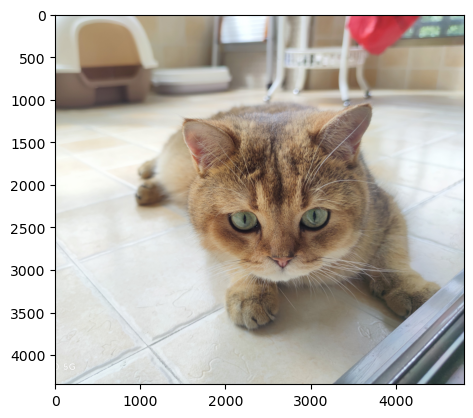

In [13]:
from PIL import Image, ImageChops
latest = model_path
latest

model.load_weights(latest)
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
im = Image.open("coco.jpg")
plt.imshow(im)
im = im.resize((32,32))
im = np.array(im, dtype = 'float32')
output = np.expand_dims(im, axis = 0)
x = model.predict(output)
print(classes[np.argmax(x[-1], axis = 1)[0]])
